In [1]:
#### IMPORTING LIBRARIES ####
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import pyroomacoustics as pra
from scipy.io import wavfile 
from scipy.signal import chirp, spectrogram, find_peaks
from scipy import interpolate
from scipy.optimize import minimize
import IPython
from playsound import playsound 
import simpleaudio as sa
  

In [2]:
#### GENERATING THE SINE SWEEP ####
w1 = 1
w2 = 1
fs = 44100
T = 1
t = np.linspace(0,T,T*fs)
sweep = np.sin((w1*T/np.log(w2/w1))*(np.exp((t/T)*np.log(w2/w1)) - 1))
audio = sweep * (2**15 - 1) / np.max(np.abs(sweep))
audio = audio.astype(np.int16)

c:\users\salma\documents\manuel\universidad\master\segundoaño\segundo\project course\calibration\project-course\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys
c:\users\salma\documents\manuel\universidad\master\segundoaño\segundo\project course\calibration\project-course\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


## These next 2 cells are just for creating the wav file.

In [3]:
#fs, audio = wavfile.read("examples_input_samples_cmu_arctic_us_axb_a0006.wav")

In [3]:
#play_obj = sa.play_buffer(audio, 1, 2, fs)
#play_obj.wait_done()
#wavfile.write('sweep3266641.wav', fs, audio)
#playsound('sweep3266641.wav')

In [76]:
RIR1 = wavfile.read("rir_source_1.wav")
#Comentario

1076

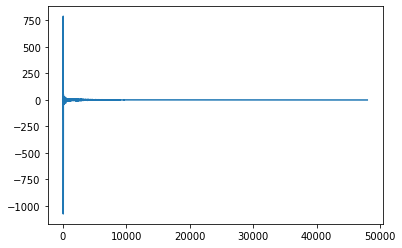

In [160]:
plt.figure()
plt.plot(RIR1[1][:,0])
a = np.amax(abs(RIR1[1][:,0]))
a

In [131]:
Xmics_rir = np.zeros(shape=(RIR1[1].shape[1]))
Ymics_rir = np.zeros(shape=(RIR1[1].shape[1]))
Ymics[0] = 0;
for i in range(1,32):
    Ymics_rir[i] = Ymics_rir[i - 1] + 0.03
    
print(Ymics_rir)

[0.   0.03 0.06 0.09 0.12 0.15 0.18 0.21 0.24 0.27 0.3  0.33 0.36 0.39
 0.42 0.45 0.48 0.51 0.54 0.57 0.6  0.63 0.66 0.69 0.72 0.75 0.78 0.81
 0.84 0.87 0.9  0.93]


c:\users\salma\documents\manuel\universidad\master\segundoaño\segundo\project course\calibration\project-course\lib\site-packages\pyroomacoustics\room.py:1049: UserWarning: Using absorption parameter is deprecated. In the future, use materials instead.
  "Using absorption parameter is deprecated. In the future, use materials instead."
c:\users\salma\documents\manuel\universidad\master\segundoaño\segundo\project course\calibration\project-course\lib\site-packages\pyroomacoustics\room.py:1412: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = a3.Axes3D(fig)


(0.0, 4.0)

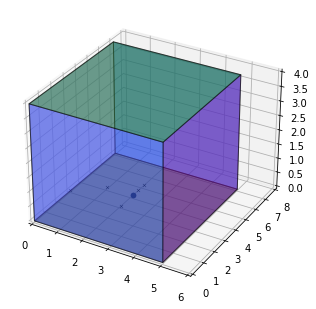

In [43]:
#### DESIGNING THE ROOM ####
fs = 96000*4;
c = 343;
pol = np.array([[0,0], [0,7], [5,7], [5,0]]).T
room = pra.Room.from_corners(pol, fs = fs, max_order=0, absorption=1, ray_tracing = False, air_absorption = False, t0 = 0.0)
room.extrude(4,absorption = 1)
# Adding the source
nSources = 1;
Xsource = np.array([3])
Ysource = np.array([2])
Zsource = np.array([1])

room.add_source(np.array([Xsource[0],Ysource[0],Zsource[0]]))
#room.add_source(np.array([Xsource[1],Ysource[1],Zsource[1]]), signal= 'sweep3266641.wav')

# Adding the microphone
Xmics = [3,3,2,1,3]
Ymics =[3,2.5,2,1,1]
Zmics = [1,1,1,1,1]
R = np.array([Xmics,Ymics,Zmics])
room.add_microphone_array(pra.MicrophoneArray(R, room.fs))

fig, ax = room.plot()
ax.set_xlim([0,6])
ax.set_ylim([0,8])
ax.set_zlim([0,4])

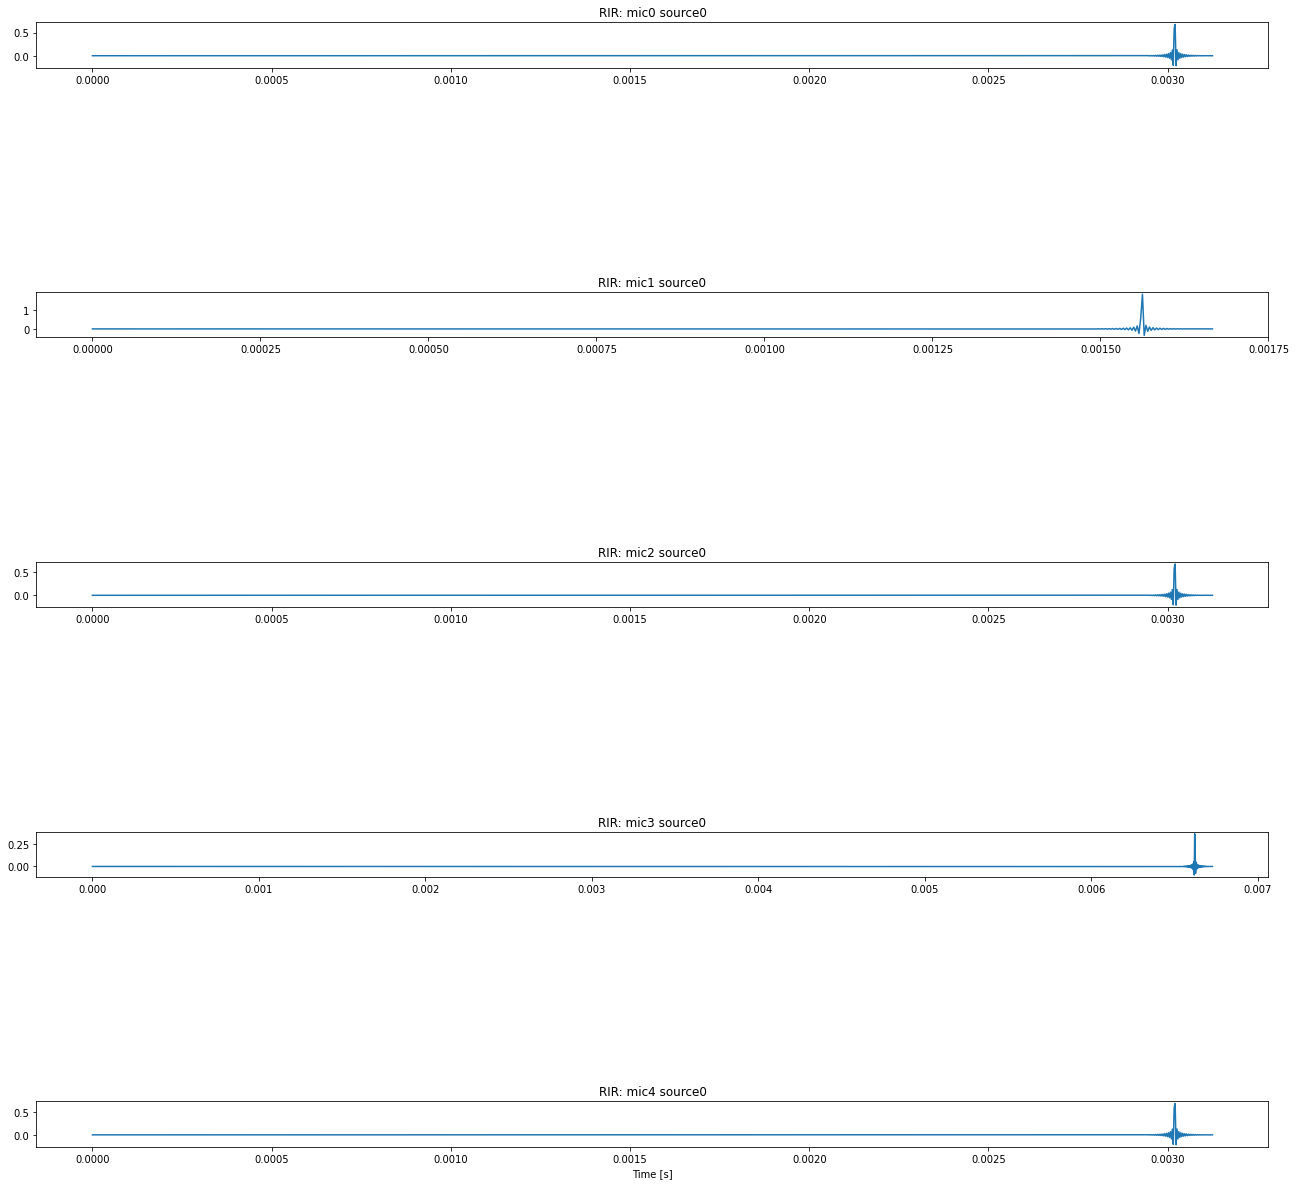

In [44]:
#### COMPUTING RIR ####
RIR = room.compute_rir()
# Plot and apply the RIR on the audio file
room.plot_rir()
fig = plt.gcf()
fig.set_size_inches(20.5, 20.5)
RIRR = plt.show()

In [14]:
def find_directPath(this_rir, top_peaks=15):
    this_rir = np.abs(this_rir)
    peaks, _ = find_peaks(this_rir)
    nHighest = (this_rir[peaks]).argsort()[::-1][:top_peaks]
    dp = np.sort((peaks[nHighest]))[:1]
    return dp

In [124]:
toa1 = np.zeros(shape=(RIR1[1].shape[1]))
interp_factor = 10
do_interpolation = True
for m in range(0,RIR1[1].shape[1]):
    if do_interpolation:
        this_rir = RIR1[1][:,m]
        sample_ax = np.arange(0, this_rir.shape[0])
        f = interpolate.interp1d(sample_ax, this_rir, kind='quadratic')
        sample_ax_new = np.arange(0, this_rir.shape[0]-1, 1/interp_factor)
        dp = find_directPath(f(sample_ax_new))
    else:
        this_rir = RIR1[1][:,m]
        dp = find_directPath(this_rir)
    toa1[m] = (dp/interp_factor)*(1/fs) * c
    
print(toa1)


[0.04430417 0.0417138  0.04162448 0.03983802 0.04028464 0.03948073
 0.0409099  0.04099922 0.04350026 0.04430417 0.0471625  0.04859167
 0.05180729 0.05359375 0.05734531 0.05948906 0.06324062 0.06574167
 0.06958255 0.07199427 0.0760138  0.07842552 0.08280234 0.08539271
 0.08976953 0.09209193 0.09637943 0.09905911 0.10343594 0.10611562
 0.11058177 0.11326146]


In [88]:
toa = np.zeros(shape=(len(Xmics)))
interp_factor = 10
do_interpolation = True
for m in range(0,len(Xmics)):
    if do_interpolation:
        this_rir = room.rir[m][0]
        sample_ax = np.arange(0, this_rir.shape[0])
        f = interpolate.interp1d(sample_ax, this_rir, kind='quadratic')
        sample_ax_new = np.arange(0, this_rir.shape[0]-1, 1/interp_factor)
        dp = find_directPath(f(sample_ax_new))
    else:
        this_rir = room.rir[m][0]
        dp = find_directPath(this_rir)
    toa[m] = (dp/interp_factor)*(1/fs) * c
    
print(toa)
print(this_rir.shape)


[1.029      0.52879167 1.029      2.26522917 1.029     ]
(1201,)


In [141]:
dist1 = 0

path = find_directPath(RIR1[1][:,0])
dist1 = path * c/fs;
print(path)

[51]


In [69]:
#### COMPUTING TIME OF FIRST REFLECTION (1 SOURCE) ####
time = [0,0,0,0,0,0];
for m in range(0,len(Xmics)):
    for n in range(1,len(room.rir[m][0]) - 1):
        if ((room.rir[m][0][n - 1] < room.rir[m][0][n]) & (room.rir[m][0][n + 1] < room.rir[m][0][n]) & (room.rir[m][0][n] > np.mean(room.rir[m][0]))):
            time[m] = n/fs;
            break;
    print('Room Impulse Response Mic', m,' empieza en: ', time[m], 'segundos')
    print('Muestra numero:', n)


Room Impulse Response Mic 0  empieza en:  0.002934895833333333 segundos
Muestra numero: 1127
Room Impulse Response Mic 1  empieza en:  0.008260416666666666 segundos
Muestra numero: 3172
Room Impulse Response Mic 2  empieza en:  0.002934895833333333 segundos
Muestra numero: 1127
Room Impulse Response Mic 3  empieza en:  0.006533854166666667 segundos
Muestra numero: 2509
Room Impulse Response Mic 4  empieza en:  0.002934895833333333 segundos
Muestra numero: 1127


In [5]:
#### COMPUTING TIME OF FIRST REFLECTION (MORE THAN 1 SOURCE) ####
time = [[0,0,0,0],[0,0,0,0]];

for m in range(0,len(Xmics)):
    for t in range(0,nSources):
        for n in range(1,len(room.rir[m][0]) - 1):
            if ((room.rir[m][t][n - 1] < room.rir[m][t][n]) & (room.rir[m][t][n + 1] < room.rir[m][t][n]) & (room.rir[m][t][n] > np.mean(room.rir[m][t]))):
                time[t][m] = n/16000;
                #print('Room Impulse Response empieza en: ', time, 'segundos')
                #print('Muestra numero:', n)
                break;
        print('Room Impulse Response Mic', m,'Source', t, 'empieza en: ', time[t][m], 'segundos')
        print('Muestra numero:', n)

Room Impulse Response Mic 0 Source 0 empieza en:  0.004625 segundos
Muestra numero: 74
Room Impulse Response Mic 0 Source 1 empieza en:  0.006625 segundos
Muestra numero: 106
Room Impulse Response Mic 1 Source 0 empieza en:  0.0078125 segundos
Muestra numero: 125
Room Impulse Response Mic 1 Source 1 empieza en:  0.012625 segundos
Muestra numero: 202
Room Impulse Response Mic 2 Source 0 empieza en:  0.014125 segundos
Muestra numero: 226
Room Impulse Response Mic 2 Source 1 empieza en:  0.0080625 segundos
Muestra numero: 129
Room Impulse Response Mic 3 Source 0 empieza en:  0.012875 segundos
Muestra numero: 206
Room Impulse Response Mic 3 Source 1 empieza en:  0.006625 segundos
Muestra numero: 106


In [46]:
#### COMPUTING DISTANCE BETWEEN MIC AND SOURCE ####

Xmics_ = np.asarray(Xmics)
Ymics_ = np.asarray(Ymics)
Zmics_ = np.asarray(Zmics)
distance_real = []
for i in range(0, len(Xmics)):
    distance_real.append(np.sqrt(abs(Xsource - Xmics_[i])**2 + abs(Ysource - Ymics_[i])**2));
    
    print('Real distance between mic', i,'and source:', distance_real[i], 'metros');
    print('Distance according to RIR of mic',i,':', toa[i], 'metros')
    print('Delay of mic',i,':', (abs(distance_real[i] - toa[i]))*1000/c, 'miliseconds \n')

Real distance between mic 0 and source: [1.] metros
Distance according to RIR of mic 0 : 1.029 metros
Delay of mic 0 : [0.0845481] miliseconds 

Real distance between mic 1 and source: [0.5] metros
Distance according to RIR of mic 1 : 0.5287916666666667 metros
Delay of mic 1 : [0.08394072] miliseconds 

Real distance between mic 2 and source: [1.] metros
Distance according to RIR of mic 2 : 1.029 metros
Delay of mic 2 : [0.0845481] miliseconds 

Real distance between mic 3 and source: [2.23606798] metros
Distance according to RIR of mic 3 : 2.2652291666666664 metros
Delay of mic 3 : [0.08501804] miliseconds 

Real distance between mic 4 and source: [1.] metros
Distance according to RIR of mic 4 : 1.029 metros
Delay of mic 4 : [0.0845481] miliseconds 



In [94]:
##OPTIMIZATION PROBLEM USING THE REAL DISTANCE. THE DELAY IS NOT TAKEN INTO ACCOUNT
def fun2(x1):
  
    P = [0,0,0,0,0,0];
    D = [0,0,0,0,0,0];
    
    for i in range(0, len(Xmics)):
        P[i] = (np.sqrt(abs(x1[0] - Xmics_[i])**2 + abs(x1[1] - Ymics_[i])**2))
        D[i] = (np.sqrt(abs(sum(Xsource) - Xmics_[i])**2 + abs(sum(Ysource) - Ymics_[i])**2)) 
    P = np.array(P).T
    D = np.array(D).T
    return sum((P - D)**2);
bndsM = ((0,5),(0,4))
resM = minimize(fun2, (2.5,2), method='SLSQP', bounds=bndsM)
print(resM.x)

[2.99998309 2.00001903]


In [47]:
##OPTIMIZATION PROBLEM USING DELAY.
def fun2(x1):
  
    P = [0,0,0,0,0];
    D = [0,0,0,0,0];
    T = [x1[2]*c,x1[2]*c,x1[2]*c,x1[2]*c,x1[2]*c];
    for i in range(0, 5):
        P[i] = (np.sqrt(abs(x1[0] - Xmics_[i])**2 + abs(x1[1] - Ymics_[i])**2))
        #D[i] = (np.sqrt(abs(sum(Xsource) - Xmics_[i])**2 + abs(sum(Ysource) - Ymics_[i])**2))
        D[i] = toa[i];   
    P = np.array(P).T
    D = np.array(D).T
    return sum((P - (D - T))**2);
bndsM = ((0,7),(0,7),(0,0.5))
resM = minimize(fun2, (2,2,0), method='SLSQP', bounds=bndsM)
print(resM.x)

[3.00011194e+00 2.00011076e+00 8.43841076e-05]


In [130]:
##OPTIMIZATION PROBLEM USING DELAY.
def fun2(x1):
  
    P = np.zeros(shape=(RIR1[1].shape[1]))
    D = np.zeros(shape=(RIR1[1].shape[1]))
    #T = [x1[2]*c,x1[2]*c,x1[2]*c,x1[2]*c,x1[2]*c,x1[2]*c,x1[2]*c,x1[2]*c,x1[2]*c,x1[2]*c,x1[2]*c,x1[2]*c,x1[2]*c,x1[2]*c,x1[2]*c,x1[2]*c,x1[2]*c,x1[2]*c,x1[2]*c,x1[2]*c,x1[2]*c,x1[2]*c,x1[2]*c,x1[2]*c,x1[2]*c,x1[2]*c,x1[2]*c,x1[2]*c,x1[2]*c,x1[2]*c,x1[2]*c,x1[2]*c];
    for i in range(0, RIR1[1].shape[1]):
        P[i] = (np.sqrt(abs(x1[0] - Xmics_rir[i])**2 + abs(x1[1] - Ymics_rir[i])**2))
        #D[i] = (np.sqrt(abs(sum(Xsource) - Xmics_[i])**2 + abs(sum(Ysource) - Ymics_[i])**2))
        D[i] = toa1[i];   
    P = np.array(P).T
    D = np.array(D).T
    return sum((P - D )**2);
bndsM = ((0,7),(0,7))
resM = minimize(fun2, (2,2), method='SLSQP', bounds=bndsM)
print(resM.x)

[8.67361738e-19 4.40360189e-01]
